# Imports and Functions

In [1]:
import glob

#Numpy
import numpy as np
import scipy

#For image plotting
import skimage.io
import skimage.filters as sf
from skimage import io, measure, filters, transform, morphology

#Matplotlib plotting packages
import matplotlib.pyplot as plt

# For loading bars
from tqdm.notebook import tqdm as tqdm

import pandas as pd


Soichi's functions

In [2]:
def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered

def border_clear(im_label, edge=3):
    """
    Remove objects within `edge` pixels from the image boundary

    Input
    -------
    im_label : labeled image where objects in the image are assigned positive integer value
    edge : maximum number of pixels that putative filament needs to be away from the image boundary to be rejected
    """
    im_border = np.copy(im_label)

    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    return im_border

def determine_count_nums(im_label):
    """
    Obtains maximum number of objects in the labeled image. Used to determine
    if background subtraction and thresholding must be performed on top of Niblack
    thresholding scheme.
    """
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

def remove_small(im_label, area_thresh=10):
    im_sized = np.copy(im_label)

    unique, counts = determine_count_nums(im_label)

    # Create dictionary except for 0 (background)
    dict_area = dict(zip(unique,counts))

    for label in unique:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
    
    return im_sized

def remove_circulars(im_label, eccen_thresh=0.8):
    im_eccen = im_label.copy()

    im_props = measure.regionprops_table(im_eccen,
                                        properties=['label','eccentricity'])
    df = pd.DataFrame(im_props)

    for n in np.unique(im_eccen):
        if df[df['label']==n]['eccentricity'].values < eccen_thresh:
            im_eccen[im_eccen==n] = 0

    return im_eccen

def are2lines(mt_segment, min_dist=9, min_angle=75):
    """
    Determine if putative microtubules are two microtubules. Uses
    Hough straight lines to determine if there are at least 2
    lines that can be drawn from the putative filament.
    
    Input
    -------
    mt_segment : (M, N), ndarray; cropped region about the putative
                 microtubule
    min_angle : int, minimum angle (in degrees) separating lines (default 75)
    
    Return
    -------
    len(angles)==2 : bool, determines whether there is a crossover
    """
    test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

    return len(angles)==2

def remove_line_crossovers(image, min_dist=9, min_angle=75, padding=3):
    """
    Removes microtubules that cross over in the images. 
    Input
    -------
    image : (M, N), ndarray; image from which MT crossovers are removed
    min_angle : int, minimum angle (in degrees) separating lines (default 30)
    padding : int, padding around cropped MT segments

    Return
    -------
    im_cleaned : (M, N), ndarray; image with MT crossovers removed
    """
    im_cleaned = image.copy()

    for n in np.unique(image)[1:]:
        x,y = np.where(image==n)
        mt_segment = image[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
        
        if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
            im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

    return im_cleaned

def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers

My segmentation function

In [3]:
## Func for segmenting max proj

def segment(im, block_size=3, mask_size=1, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3, plot=False):
    # #create the m=youaximum projection
    # proj = np.amax(stack-bg_avg, axis=0)
    
    #Normalize the image
    image_norm = (im - im.min()) / (im.max() - im.min())
    
    #Niblack thresholding - think like text
    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size, k=0.001)
    
    #Otsu thresholding
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)
    
    #Create a mask
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)
    
    #Label each region
    im_filtered = im_closed.copy()
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    unique_regions, region_counts = np.unique(im_label, return_counts=True)
    
    #Remove border
    im_border = np.copy(im_label)
    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    im_internal = im_border

    # Remove small regions - Create dictionary except for 0 (background)
    dict_area = dict(zip(unique_regions,region_counts))
    im_sized = np.copy(im_internal)
    for label in unique_regions:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
            
    #Thin each region - preserve connectivity but strip away any padding on the outside to get "skeleton"s
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    
    #Remove crossovers
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)
    
    #Determine properties
    im_props = measure.regionprops_table(im_noxovers, im,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
    df = pd.DataFrame(im_props)
    
    if plot==True:
        fig, ax = plt.subplots(2,3)
        
        ax[0,0].imshow(image_norm)
        ax[0,0].set_title("Normalized")
        
        ax[0,1].imshow(im_thresh)
        ax[0,1].set_title("Thresholded")
        
        ax[0,2].imshow(im_label, vmin=0, vmax=1)
        ax[0,2].set_title("labeled")
        
        ax[1,0].imshow(im_sized, vmin=0, vmax=1)
        ax[1,0].set_title("Sized")
        
        ax[1,1].imshow(im_thinned, vmin=0, vmax=0.5)
        ax[1,1].set_title("Thinned")
        
        ax[1,2].imshow(im_noxovers, vmin=0, vmax=1)
        ax[1,2].set_title("No Crossover")
    
    return im_noxovers, df

## Import Images
Import the stack of interest and a camera off background image

In [4]:
#Import Stack
file_path = '../../../../data/gliding/'
file_folder = '2023-03-23_Gliding/470/2023-Mar23_AnaGliding_Ncd-cherry-MT488_ATP470_lowATPload_5min_1/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

frames = np.arange(len(im_stack))

#Import Background
bg_file_path = '../../../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

Set the save name for figures/csv files

In [5]:
save_name = '470uMATP_5min'

## Check for anomalously bright pixels and remove
Check the maximum projection by eye, so long as everything is visible, it's fine. Otherwise need to remove something that is so bright it drowns out everything else

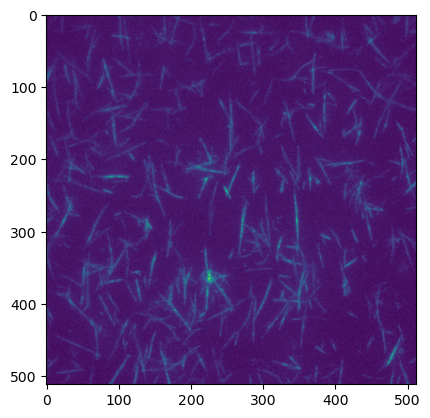

In [6]:
# Define a max projection
im_max = np.amax(im_stack, axis=0)
plt.imshow(im_max)

If something is too bright, Remove the frame with the brightest pixel. The following raw code cell works:

Create subsets of all the frames to do the max projection. Using all the r=frames can result in a very crowded image

In [7]:
#Define the number of frames you want to project over
proj_interval = 20

#Create an array of all the max proj
max_stack = []
for i in range(round(len(im_stack)/proj_interval)):
    proj = np.amax(im_stack[i*proj_interval:(i+1)*proj_interval], axis=0)
    max_stack.append(proj)
max_stack = np.array(max_stack)

## Define Properties
Here write the pixel to um conversion, as well as the thresholding parameters to be used

In [8]:
pixel_size = 0.161 #um/pixel

block_size=3
mask_size=1
edge=3
area_thresh=10
min_dist=9
min_angle=75
padding=3

# Process the Max Projection
Perform the segmentation for each image

In [9]:
# Create a list to save the processed images
max_proc_stack = []
#Create a list to store the dataframes
max_dfs = []

#loop through each projection
for i, im in enumerate(max_stack):
    im_max_processed, df_max = segment(im)
    max_proc_stack.append(im_max_processed)
    #Create a column to label the projection each row/MT comes from
    df_max['proj#'] = np.ones(len(df_max))*i
    max_dfs.append(df_max)

#Save a stack of the segmented projected images
max_proc_stack = np.array(max_proc_stack)
# Make a master list of all the datafames and reset the indices
df_max = pd.concat(max_dfs).reset_index()

Visualize each step of the thresholding

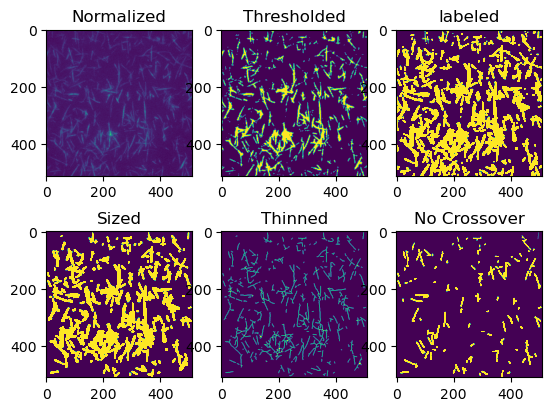

In [10]:
segment(im_max, plot=True);

## Generate Kymographs from max proj
Function that takes the properties of a segmented region and finds the x and y vlaues of pixels corresponding to the major-axis line. This will be how we define tracks

In [11]:
def mt_track(xc, yc, l, theta):
    if theta>=np.pi:
        theta = theta-np.pi
    if np.abs(theta)<=np.pi/4:
        xvals = np.arange(xc - np.abs(0.5*l*np.cos(theta)), xc + np.abs(0.5*l*np.cos(theta)))#.astype(int)
        yvals = (np.tan(theta)*xvals + (yc - np.tan(theta)*xc))#.astype(int)
    else:
        yvals = np.arange(yc - np.abs(0.5*l*np.sin(theta)), yc + np.abs(0.5*l*np.sin(theta)))#.astype(int)
        xvals = (yvals/np.tan(theta) + (xc - yc/np.tan(theta)))#.astype(int)
    
    return xvals, yvals

Visualize a track on the image

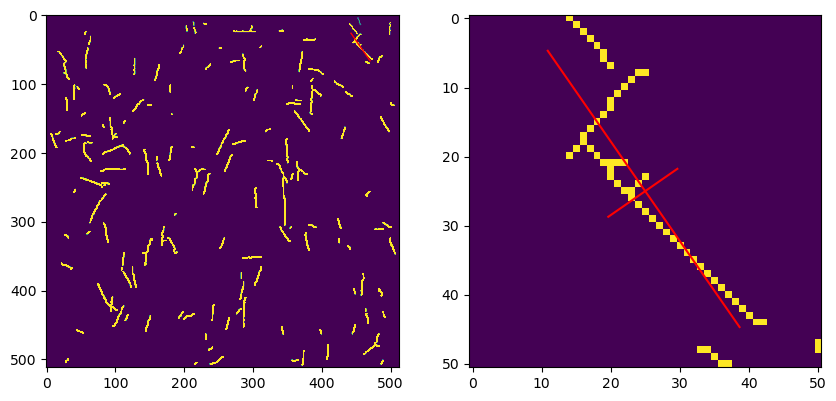

In [51]:
i = 10
proj_num = 0

# Calculate line
xc =  df_max.loc[i, 'centroid-1']
yc =  df_max.loc[i, 'centroid-0']
lmajor =  df_max.loc[i, 'major_axis_length']
lminor =  df_max.loc[i, 'minor_axis_length']
theta = -df_max.loc[i, 'orientation'] + (np.pi/2)

xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
#full frame
ax[0].imshow(max_proc_stack[proj_num], vmin=0, vmax=1)
ax[0].plot(xmajor, ymajor, color='r', lw=1)
#ax[0].scatter(xc, yc, color='r')

#Define crop
crop_win = int(lmajor/2+1)
cropmajx = xmajor-xc + crop_win #np.arange(crop_win - np.abs(0.5*l*np.cos(theta)), np.abs(crop_win + 0.5*l*np.cos(theta))).astype(int)
cropmajy = ymajor-yc + crop_win #(np.tan(theta)*(cropx) - 0.5*l*np.sin(theta))# - np.tan(theta)*(crop_win)).astype(int)
cropminx = xminor-xc + crop_win 
cropminy = yminor-yc + crop_win

ax[1].imshow(max_proc_stack[proj_num][int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)], vmin=0, vmax=1)
ax[1].plot(cropmajx, cropmajy, color='r')
ax[1].plot(cropminx, cropminy, color='r')
#ax[1].scatter(crop_win,crop_win, color='red')

In [52]:
len(xminor)

11

In [53]:
def kymo_func(kymo, sigma, pixel_size, plot=False):
    
    #Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu
    
    #Find the center of mass of each row
    row_coms = []
    for i, row_vals in enumerate(im_thresh):
        xdex = np.arange(len(row_vals))
        xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
        row_coms.append(xcom)
    row_coms = np.array(row_coms)
    
    #Find if there are nans
    plot_frames = np.where(~np.isnan(row_coms))[0]
    
    #Fit a line
    mfit, bfit = np.polyfit(row_coms[plot_frames], plot_frames, deg=1)
    
    #Calculate the speed (nm/s)
    speed = 1000*pixel_size/np.abs(mfit)
    
    ss_res =  np.sum((plot_frames - (mfit*row_coms[plot_frames]+bfit))**2)
    ss_tot = np.sum((plot_frames - np.average(plot_frames))**2)
    rsqrd = 1-(ss_res/ss_tot)

    #Plot
    if plot==True:
        plt.imshow(kymo)
        plt.scatter(row_coms[plot_frames], plot_frames, color='k')
        plt.plot(xdex, mfit*xdex+bfit, color='r')
        plt.title(str(np.round(speed,1)) + ' nm/s')
        plt.ylim(0, len(kymo)-1)

    return speed, rsqrd, len(plot_frames)

(67.22788904229266, 0.7709999526181435, 20)

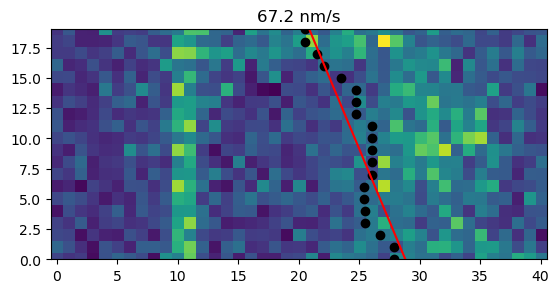

In [54]:
mykymo = []
for im in im_stack[0:proj_interval]:
    ls=[]
    for i in range(len(xmajor)):
        ls.append(im[int(ymajor[i]), int(xmajor[i])])
    mykymo.append(ls)
mykymo = np.array(mykymo)
kymo_func(mykymo, sigma = 2, pixel_size = pixel_size, plot=True)

In [16]:
ymajor.astype(int)

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124])

## Calculate Speeds

In [17]:
df_max[df_max['index']==84]

,index,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter,proj#
84,84,3,4.618802,0.000000,290.000000,187.000000,0.785398,1.000000,123,1.414214,0.0
226,84,7,8.410038,1.052615,276.714286,98.000000,-1.254674,0.992136,122,5.621320,1.0
368,84,11,13.055448,1.091619,291.000000,107.000000,0.251045,0.996498,121,9.828427,2.0
510,84,42,45.358317,3.794243,300.571429,270.404762,-0.111443,0.996495,117,44.177670,3.0
646,84,17,25.899822,1.144538,304.000000,398.588235,0.713537,0.999023,116,20.177670,4.0


In [45]:
speeds=[]
r2 = []
num_centr = []

for i in range(len(df_max)):

    xc =  df_max.loc[i, 'centroid-1']
    yc =  df_max.loc[i, 'centroid-0']
    l =  df_max.loc[i, 'major_axis_length']
    theta = -df_max.loc[i, 'orientation'] + (np.pi/2)
    
    xtrack, ytrack = mt_track(xc, yc, l, theta)
    
    if len(xtrack)>1:
        mykymo = []

        for im in im_stack:
            ls=[]
            for i in range(len(xtrack)):
                if int(ytrack[i])<512 and int(xtrack[i])<512:
                    ls.append(im[int(ytrack[i]), int(xtrack[i])])
            mykymo.append(ls)
        mykymo = np.array(mykymo)

        speed, rsqrd, num_centroids = kymo_func(mykymo, sigma = 1, pixel_size = pixel_size)
        speeds.append(speed)
        r2.append(rsqrd)
        num_centr.append(num_centroids)
    else:
        df_max=df_max.drop([i])
speeds = np.array(speeds)
r2 = np.array(r2)
num_centr = np.array(num_centr)
df_max['speed (nm/s)'] = speeds
df_max['r^2'] = r2
df_max['num points'] = num_centr

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_3733/97330233.py:14: RuntimeWarning: invalid value encountered in long_scalars
  xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_3733/97330233.py:14: RuntimeWarning: invalid value encountered in long_scalars
  xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_3733/97330233.py:14: RuntimeWarning: invalid value encountered in long_scalars
  xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_3733/97330233.py:14: RuntimeWarning: invalid value encountered in long_scalars
  xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_3733/97330233.py:14: RuntimeWarning: invalid value encountered in long_scalars
  xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_3733/973302

Sort the speeds and plot the ecdf

[Text(0, 0.0, '0.0'),
 Text(0, 0.25, '0.25'),
 Text(0, 0.5, '0.50'),
 Text(0, 0.75, '0.75'),
 Text(0, 1.0, '1.0')]

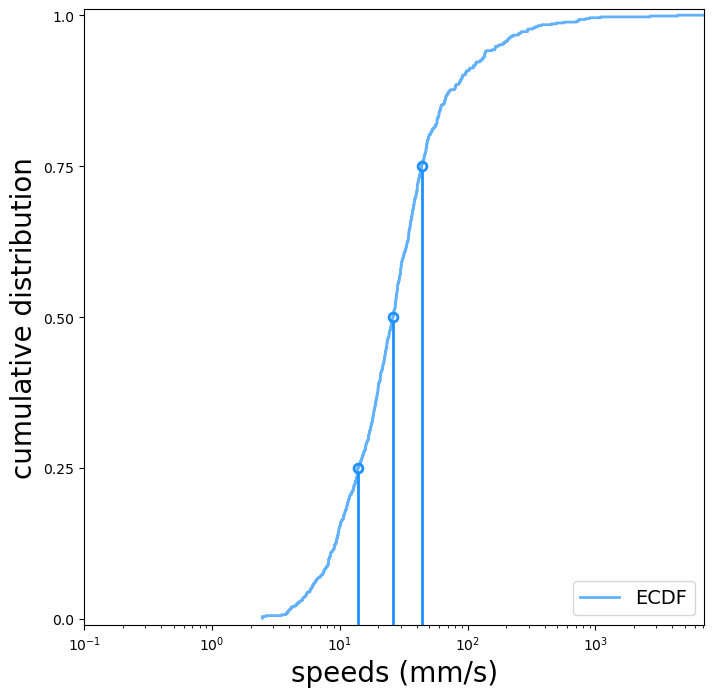

In [46]:
speedsort = np.sort(speeds)
ecdf = np.arange(1, len(speeds)+1, 1) /len(speeds)

q_25 = np.percentile(speedsort, 25)
q_50 = np.percentile(speedsort, 50)
q_75 = np.percentile(speedsort, 75)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.step(speedsort, ecdf, label='ECDF', color='dodgerblue', lw=2, zorder=4, alpha=0.7)

ax.scatter(q_25, 0.25, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_50, 0.50, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_75, 0.75, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)

ax.axvline(q_25, 0, 0.25, color='dodgerblue', lw=2)
ax.axvline(q_50, 0, 0.50, color='dodgerblue', lw=2)
ax.axvline(q_75, 0, 0.75, color='dodgerblue', lw=2)

ax.set_xlim([0.1,np.max(speedsort)])
ax.set_ylim([-0.01,1.01])
ax.set_xlabel('speeds (mm/s)', fontsize=20)
ax.set_ylabel('cumulative distribution', fontsize=20)
ax.legend(fontsize=14, loc=4)
ax.set_xscale('log')

# ax.set_xticks([0.1, q_25, q_50, q_75, 10])
# ax.set_xticklabels(['0.1', '%.1f' %q_25, '%.1f' %q_50, '%.1f' %q_75, '10'])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.0', '0.25', '0.50', '0.75', '1.0'])

# plt.savefig('../figures/SIFigX_MT_length_RB_manuscript.pdf', bbox_inches='tight',
#             facecolor='white')

Filter out rows that have too few points to fit or have a low r^2

In [47]:
df_good_ones = df_max[df_max['r^2']>0.8][df_max['num points']>20]
#df_good_ones.to_csv(save_name + '.csv', sep=',');

print('Number of Viable Tracks = ' + str(len(df_good_ones)))
print('Average Speed (nm/s) = ' + str(np.average(df_good_ones['speed (nm/s)'])))

Number of Viable Tracks = 124
Average Speed (nm/s) = 30.3233741777801


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_3733/2499214599.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_good_ones = df_max[df_max['r^2']>0.8][df_max['num points']>20]


In [48]:
df_good_ones

,index,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter,proj#,speed (nm/s),r^2,num points
10,10,47,49.482947,13.015270,46.276596,456.361702,0.606829,0.964789,15,55.669048,0.0,33.688236,0.838641,101
21,21,12,13.815083,1.016063,69.500000,127.916667,-0.031629,0.997292,29,10.621320,0.0,35.224667,0.809097,31
36,36,6,7.707964,1.214980,108.500000,290.333333,-0.488205,0.987499,51,4.828427,0.0,19.119877,0.866104,38
48,48,6,8.652106,0.834637,144.833333,53.500000,-0.906434,0.995336,69,5.242641,0.0,19.427574,0.873723,25
61,61,35,40.449977,1.465313,198.000000,348.942857,0.050724,0.999344,85,34.863961,0.0,25.536629,0.863693,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,121,21,26.509414,1.326241,453.666667,32.000000,1.151698,0.998748,167,22.520815,4.0,26.350750,0.908481,77
692,130,20,25.347349,1.397108,479.500000,214.350000,0.428298,0.998480,177,21.313708,4.0,13.420015,0.813169,101
695,133,10,11.956506,1.575423,492.600000,244.500000,0.425340,0.991281,181,9.242641,4.0,80.454431,0.887971,22
699,137,20,23.184011,1.289040,495.450000,24.500000,-1.469324,0.998453,186,18.828427,4.0,5.761682,0.805758,50


Text(0.5, 1.0, 'Average Speed (nm/s) = 30')

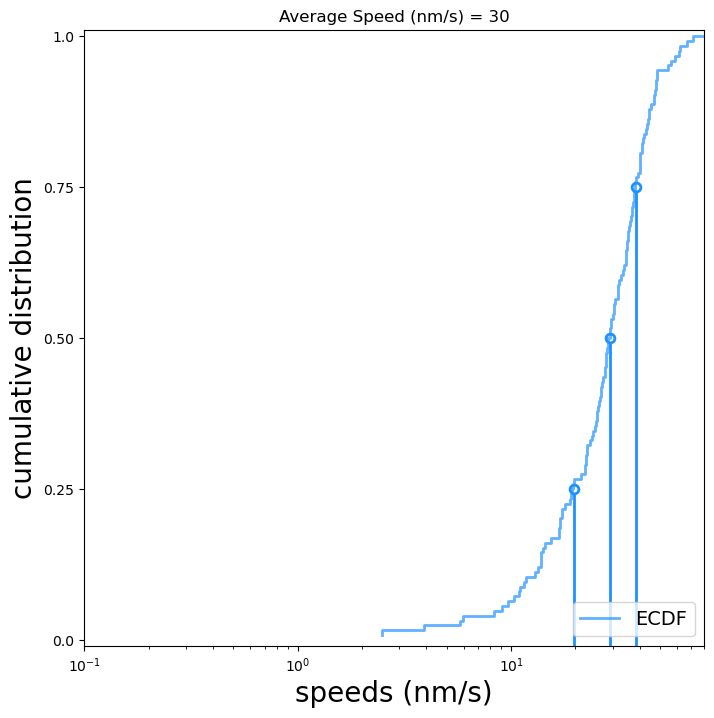

In [49]:
speedsort = np.sort(df_good_ones['speed (nm/s)'])
ecdf = np.arange(1, len(df_good_ones['speed (nm/s)'])+1, 1) /len(df_good_ones['speed (nm/s)'])

q_25 = np.percentile(speedsort, 25)
q_50 = np.percentile(speedsort, 50)
q_75 = np.percentile(speedsort, 75)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.step(speedsort, ecdf, label='ECDF', color='dodgerblue', lw=2, zorder=4, alpha=0.7)

ax.scatter(q_25, 0.25, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_50, 0.50, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_75, 0.75, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)

ax.axvline(q_25, 0, 0.25, color='dodgerblue', lw=2)
ax.axvline(q_50, 0, 0.50, color='dodgerblue', lw=2)
ax.axvline(q_75, 0, 0.75, color='dodgerblue', lw=2)

ax.set_xlim([0.1,np.max(speedsort)])
ax.set_ylim([-0.01,1.01])
ax.set_xlabel('speeds (nm/s)', fontsize=20)
ax.set_ylabel('cumulative distribution', fontsize=20)
ax.legend(fontsize=14, loc=4)
ax.set_xscale('log')

# ax.set_xticks([0.1, q_25, q_50, q_75, 10])
# ax.set_xticklabels(['0.1', '%.1f' %q_25, '%.1f' %q_50, '%.1f' %q_75, '10'])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.0', '0.25', '0.50', '0.75', '1.0'])

ax.set_title('Average Speed (nm/s) = ' + str(round(np.average(df_good_ones['speed (nm/s)']))))

Plot the remaining tracks

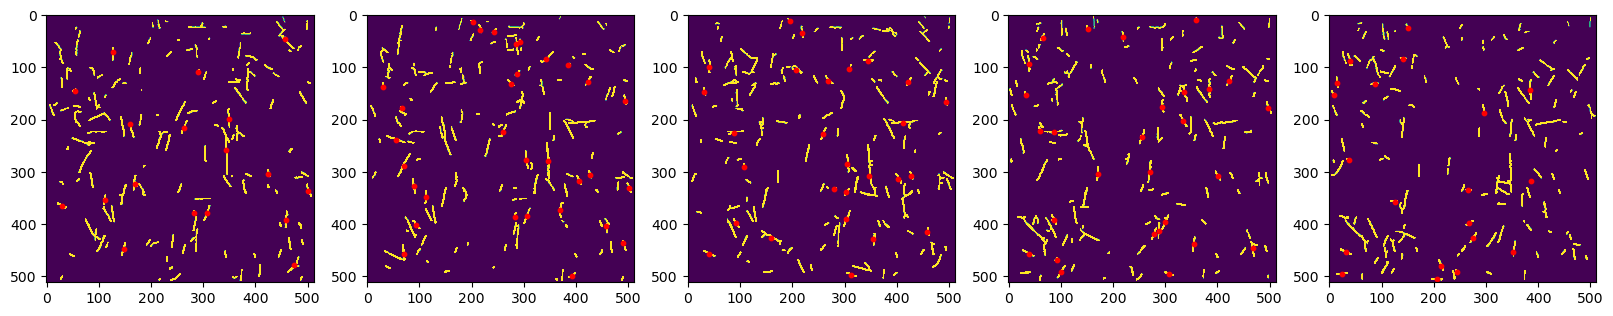

In [50]:
fig, ax = plt.subplots(1, int(len(im_stack)/proj_interval), figsize=(20, 4))
for i in range(int(len(im_stack)/proj_interval)):
    ax[i].imshow(max_proc_stack[i], vmin = 0, vmax = 0.5)
    ax[i].scatter(df_good_ones[df_good_ones['proj#']==i]['centroid-1'], df_good_ones[df_good_ones['proj#']==i]['centroid-0'], s=10, color='r')